In [1]:
# Import the necessary libraries

import shap
import optuna
import numpy as np
import pandas as pd
from catboost import Pool
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, auc, average_precision_score, roc_auc_score

/home/manju_at_ubuntu/spark-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the input csv file

df = pd.read_csv(r"../Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Check the class imbalance

df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [4]:
# Drop unnecessary featuress

df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"], inplace=True)

In [5]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [128]:
# Split the dataset into fraud and non-fraud subsets
non_fraud = df[df["isFraud"] == 0]
fraud = df[df["isFraud"] == 1]


# To handle class imbalance, we sample a subset of non-fraud transactions.
# Here, we randomly select 10 times as many non-fraud samples as there are fraud samples.
# The random_state ensures reproducibility.
non_fraud_samples = non_fraud.sample(
    n=len(fraud) * 15,
    random_state=42
)

# Concatenate both subsets to form a new balanced dataset.
# We shuffle the combined data (frac=1 shuffles all rows)
# and reset the index to avoid duplicate index values.
balanced_class_df = pd.DataFrame(
    pd.concat([non_fraud_samples, fraud])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)


# Check class distribution
print(balanced_class_df["isFraud"].value_counts())
balanced_class_df.shape

isFraud
0    123195
1      8213
Name: count, dtype: int64


(131408, 8)

In [129]:
remaining = (
    df.merge(balanced_class_df, how="left", indicator=True)
        .query('_merge == "left_only"')
        .drop(columns="_merge")
)

rem_x = remaining.drop(columns=["isFraud"])
rem_y = remaining["isFraud"]

rem_encoding = pd.get_dummies(rem_x, columns=['type'], drop_first=True)
print(remaining["isFraud"].value_counts())
rem_encoding


isFraud
0    6231199
Name: count, dtype: int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1,1,1864.28,21249.00,19384.72,0.00,0.00,False,False,True,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,False,False,True,False
5,1,7817.71,53860.00,46042.29,0.00,0.00,False,False,True,False
6,1,7107.77,183195.00,176087.23,0.00,0.00,False,False,True,False
7,1,7861.64,176087.23,168225.59,0.00,0.00,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
6362361,718,8634.29,518802.00,510167.71,0.00,0.00,False,False,True,False
6362362,718,159188.22,3859.00,0.00,0.00,159188.22,True,False,False,False
6362363,718,186273.84,168046.00,0.00,24893.67,211167.51,True,False,False,False
6362364,718,82096.45,13492.00,0.00,0.00,82096.45,False,False,False,True


In [130]:
# Separate features and target variable
bal_x = balanced_class_df.drop(columns=["isFraud"])
bal_y = balanced_class_df["isFraud"]

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(bal_x, bal_y, test_size=0.2, random_state=42)

# Encode the categorical feature
X_train = pd.get_dummies(X_train, columns=['type'], drop_first=True)

print(len(X_train), len(X_test), len(Y_train), len(Y_test))
# StratifiedKFold is used to maintain the same class ratio (fraud/non-fraud) in each fold of the dataset during cross-validation.
skf = StratifiedKFold(
    n_splits=3,
    shuffle=True,        # Shuffle before splitting to ensure randomness
    random_state=42
)


105126 26282 105126 26282


In [131]:
# ============================================================
# XGBoost Hyperparameter Optimization using Optuna
# ============================================================
# This section performs automated hyperparameter tuning for an XGBoost classifier using Optuna and Stratified K-Fold
# cross-validation. The goal is to maximize the F1 score for a binary fraud detection task.

def xgb_objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.

    Parameters:
        trial (optuna.trial.Trial): A single optimization trial instance.
    
    Returns:
        float: The mean F1 score across all cross-validation folds.
    """
    
    # Define the hyperparameter search space
    param = {
        'objective': 'binary:logistic',       # Binary classification
        'eval_metric': 'aucpr',               # Area under PR curve (good for imbalance)
        'tree_method': 'hist',                # Fast histogram-based algorithm
        'predictor': 'gpu_predictor',         # Use GPU acceleration
        'device': 'gpu',                      # Ensure GPU training
        'max_depth': trial.suggest_int('max_depth', 4, 6),            # Tree depth
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),  # Step size
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),      # Row sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),  # Feature sampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),          # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 5),        # L2 regularization
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000), # Number of boosting rounds
        'n_jobs': -1,                                                 # Use all CPU threads
        'grow_policy': 'lossguide',                                   # Efficient tree growth
        'early_stopping_rounds': 50                                   # Early stopping to avoid overfitting
    }

    # Initialize model with suggested parameters
    model = XGBClassifier(**param)
    f1_scores = []

    # Perform Stratified K-Fold Cross-Validation
    # for fold, (train_idx, val_idx) in enumerate(skf.split(bal_x, bal_y)):
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
        print(f"\nFold {fold + 1}")
        
        # Split into training and validation sets
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
        # Train the model
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            verbose=False
        )
        
        # Predict probabilities and convert to binary labels
        y_pred_prob = model.predict_proba(x_val)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)
        
        # Evaluate using F1 score (harmonic mean of precision and recall)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        print(f"Fold {fold + 1} F1 Score: {f1:.4f}")

    # Compute mean F1 score across all folds
    mean_f1 = np.mean(f1_scores)
    print(f"\nMean F1 Score across folds: {mean_f1:.4f}")
    
    # Return metric to be maximized by Optuna
    return mean_f1

# Optuna will:
#   - Call the objective function multiple times (n_trials)
#   - Keep track of the best parameter set
#   - Use pruning to skip unpromising trials early

xgb_study = optuna.create_study(
    direction='maximize',                       # Maximize F1 score
    study_name='XGB_GPU',                       # Study identifier
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)  # Prune bad trials
)

# Run optimization
xgb_study.optimize(xgb_objective, n_trials=20)  # 20 trials for demo (increase for better tuning)

# Display the Best Results
print("\nBest XGBoost Parameters (subset):")
print(xgb_study.best_params)


[I 2025-12-30 23:48:13,454] A new study created in memory with name: XGB_GPU



Fold 1
[23:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9742

Fold 2
[23:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9706

Fold 3
[23:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:48:23,050] Trial 0 finished with value: 0.974197779140393 and parameters: {'max_depth': 4, 'learning_rate': 0.13458496311636242, 'subsample': 0.6616627769979063, 'colsample_bytree': 0.7581498343051531, 'reg_alpha': 0.5219288393640826, 'reg_lambda': 2.316285175974661, 'n_estimators': 655}. Best is trial 0 with value: 0.974197779140393.


Fold 3 F1 Score: 0.9778

Mean F1 Score across folds: 0.9742

Fold 1
[23:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9760

Fold 2
[23:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9732

Fold 3
[23:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:48:38,661] Trial 1 finished with value: 0.9753615682764042 and parameters: {'max_depth': 4, 'learning_rate': 0.05042051484503769, 'subsample': 0.7572007359583353, 'colsample_bytree': 0.782982181250709, 'reg_alpha': 0.22126660056061764, 'reg_lambda': 1.0027427819572825, 'n_estimators': 843}. Best is trial 1 with value: 0.9753615682764042.


Fold 3 F1 Score: 0.9769

Mean F1 Score across folds: 0.9754

Fold 1
[23:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9708

Fold 2
[23:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9664

Fold 3
[23:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:48:51,189] Trial 2 finished with value: 0.9703180565387178 and parameters: {'max_depth': 4, 'learning_rate': 0.057310627801071594, 'subsample': 0.6318196786714121, 'colsample_bytree': 0.6280225217087286, 'reg_alpha': 0.7355368496895005, 'reg_lambda': 3.118004401608752, 'n_estimators': 569}. Best is trial 1 with value: 0.9753615682764042.


Fold 3 F1 Score: 0.9737

Mean F1 Score across folds: 0.9703

Fold 1
[23:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9747

Fold 2
[23:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9704

Fold 3
[23:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:49:07,867] Trial 3 finished with value: 0.9738221632563447 and parameters: {'max_depth': 4, 'learning_rate': 0.06212560991608551, 'subsample': 0.7569718770718713, 'colsample_bytree': 0.757177139432174, 'reg_alpha': 0.7162772312505713, 'reg_lambda': 2.7037599144068256, 'n_estimators': 769}. Best is trial 1 with value: 0.9753615682764042.


Fold 3 F1 Score: 0.9764

Mean F1 Score across folds: 0.9738

Fold 1
[23:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9739

Fold 2
[23:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9716

Fold 3
[23:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:49:24,254] Trial 4 finished with value: 0.9742716922659072 and parameters: {'max_depth': 5, 'learning_rate': 0.05907268830114019, 'subsample': 0.7078748266706771, 'colsample_bytree': 0.6288599391880783, 'reg_alpha': 0.9505481071677774, 'reg_lambda': 2.7690427475524677, 'n_estimators': 914}. Best is trial 1 with value: 0.9753615682764042.


Fold 3 F1 Score: 0.9773

Mean F1 Score across folds: 0.9743

Fold 1
[23:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9742

Fold 2
[23:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9711

Fold 3
[23:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:49:35,533] Trial 5 finished with value: 0.9738578699531654 and parameters: {'max_depth': 4, 'learning_rate': 0.13792890424951748, 'subsample': 0.6171483079495605, 'colsample_bytree': 0.6927349944833693, 'reg_alpha': 0.15689235115551903, 'reg_lambda': 2.6836918484269754, 'n_estimators': 687}. Best is trial 1 with value: 0.9753615682764042.


Fold 3 F1 Score: 0.9763

Mean F1 Score across folds: 0.9739

Fold 1
[23:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9740

Fold 2
[23:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9718

Fold 3
[23:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:49:48,628] Trial 6 finished with value: 0.9746535448038435 and parameters: {'max_depth': 4, 'learning_rate': 0.09712256449710843, 'subsample': 0.7634128527953739, 'colsample_bytree': 0.6337014833218553, 'reg_alpha': 0.7297483915330988, 'reg_lambda': 1.850579157912752, 'n_estimators': 725}. Best is trial 1 with value: 0.9753615682764042.


Fold 3 F1 Score: 0.9782

Mean F1 Score across folds: 0.9747

Fold 1
[23:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9753

Fold 2
[23:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9722

Fold 3
[23:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:00,411] Trial 7 finished with value: 0.9756670665973907 and parameters: {'max_depth': 4, 'learning_rate': 0.12832508556710742, 'subsample': 0.7813078432235288, 'colsample_bytree': 0.7978486190865828, 'reg_alpha': 0.11635931467668692, 'reg_lambda': 2.842293606249169, 'n_estimators': 959}. Best is trial 7 with value: 0.9756670665973907.


Fold 3 F1 Score: 0.9794

Mean F1 Score across folds: 0.9757

Fold 1
[23:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9746

Fold 2
[23:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9718

Fold 3
[23:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:08,094] Trial 8 finished with value: 0.9754833529780731 and parameters: {'max_depth': 6, 'learning_rate': 0.14028313868187609, 'subsample': 0.7128968279066648, 'colsample_bytree': 0.71502249231458, 'reg_alpha': 0.05869866921536948, 'reg_lambda': 2.5699965456275504, 'n_estimators': 366}. Best is trial 7 with value: 0.9756670665973907.


Fold 3 F1 Score: 0.9801

Mean F1 Score across folds: 0.9755

Fold 1
[23:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9744

Fold 2
[23:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9709

Fold 3
[23:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:16,111] Trial 9 finished with value: 0.974131443623656 and parameters: {'max_depth': 5, 'learning_rate': 0.123260877938905, 'subsample': 0.6625467717016932, 'colsample_bytree': 0.7435743311964655, 'reg_alpha': 0.6402864789066947, 'reg_lambda': 1.863680131177348, 'n_estimators': 574}. Best is trial 7 with value: 0.9756670665973907.


Fold 3 F1 Score: 0.9771

Mean F1 Score across folds: 0.9741

Fold 1
[23:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9742

Fold 2
[23:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9732

Fold 3
[23:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:23,991] Trial 10 finished with value: 0.9753682401858782 and parameters: {'max_depth': 6, 'learning_rate': 0.10561482942359077, 'subsample': 0.7898284857445823, 'colsample_bytree': 0.7971464968024511, 'reg_alpha': 0.3155879548996209, 'reg_lambda': 4.168757549419622, 'n_estimators': 303}. Best is trial 7 with value: 0.9756670665973907.


Fold 3 F1 Score: 0.9787

Mean F1 Score across folds: 0.9754

Fold 1
[23:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9737

Fold 2
[23:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9713

Fold 3
[23:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:31,548] Trial 11 finished with value: 0.9739329029319147 and parameters: {'max_depth': 6, 'learning_rate': 0.14859145710447885, 'subsample': 0.7090281413209162, 'colsample_bytree': 0.6995492856070179, 'reg_alpha': 0.000569834576141133, 'reg_lambda': 3.5839460824474743, 'n_estimators': 340}. Best is trial 7 with value: 0.9756670665973907.


Fold 3 F1 Score: 0.9769

Mean F1 Score across folds: 0.9739

Fold 1
[23:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9751

Fold 2
[23:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9736

Fold 3
[23:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:40,384] Trial 12 finished with value: 0.976012265103611 and parameters: {'max_depth': 6, 'learning_rate': 0.11304085005613967, 'subsample': 0.7978757758124434, 'colsample_bytree': 0.6661073922032411, 'reg_alpha': 0.018249624395992523, 'reg_lambda': 3.749653132188264, 'n_estimators': 998}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9794

Mean F1 Score across folds: 0.9760

Fold 1
[23:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9749

Fold 2
[23:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9711

Fold 3
[23:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:50:51,449] Trial 13 finished with value: 0.9749633180943236 and parameters: {'max_depth': 5, 'learning_rate': 0.11022564629309915, 'subsample': 0.7963628429989187, 'colsample_bytree': 0.6674479793908424, 'reg_alpha': 0.3726778377777339, 'reg_lambda': 4.959385075623883, 'n_estimators': 991}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9789

Mean F1 Score across folds: 0.9750

Fold 1
[23:50:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9746

Fold 2
[23:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9709

Fold 3
[23:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:51:05,985] Trial 14 finished with value: 0.974401442172272 and parameters: {'max_depth': 5, 'learning_rate': 0.0874716205049696, 'subsample': 0.7415117355769127, 'colsample_bytree': 0.6650428256338471, 'reg_alpha': 0.13181954430426313, 'reg_lambda': 3.8276061832743484, 'n_estimators': 1000}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9778

Mean F1 Score across folds: 0.9744

Fold 1
[23:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9746

Fold 2
[23:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9729

Fold 3
[23:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:51:17,373] Trial 15 finished with value: 0.9756352830307163 and parameters: {'max_depth': 6, 'learning_rate': 0.12098913443545115, 'subsample': 0.7970720050189684, 'colsample_bytree': 0.6646035684364998, 'reg_alpha': 0.31009829745303696, 'reg_lambda': 4.532288453011256, 'n_estimators': 875}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9794

Mean F1 Score across folds: 0.9756

Fold 1
[23:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9757

Fold 2
[23:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9718

Fold 3
[23:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:51:30,373] Trial 16 finished with value: 0.9754123570460935 and parameters: {'max_depth': 5, 'learning_rate': 0.07812352972078726, 'subsample': 0.7742716925867889, 'colsample_bytree': 0.6020395252653812, 'reg_alpha': 0.0019461306248140554, 'reg_lambda': 3.3614143333941553, 'n_estimators': 813}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9787

Mean F1 Score across folds: 0.9754

Fold 1
[23:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9739

Fold 2
[23:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9715

Fold 3
[23:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:51:40,605] Trial 17 finished with value: 0.9748704372397045 and parameters: {'max_depth': 6, 'learning_rate': 0.12370142062316301, 'subsample': 0.7358990160021208, 'colsample_bytree': 0.7251453871301103, 'reg_alpha': 0.46117688974163484, 'reg_lambda': 3.9924746216262, 'n_estimators': 930}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9791

Mean F1 Score across folds: 0.9749

Fold 1
[23:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9747

Fold 2
[23:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9724

Fold 3
[23:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:51:51,164] Trial 18 finished with value: 0.9748693340498852 and parameters: {'max_depth': 5, 'learning_rate': 0.11524883112126436, 'subsample': 0.6752469862772954, 'colsample_bytree': 0.6826400970944718, 'reg_alpha': 0.19523905419370996, 'reg_lambda': 3.253346534392158, 'n_estimators': 435}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9775

Mean F1 Score across folds: 0.9749

Fold 1
[23:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 1 F1 Score: 0.9747

Fold 2
[23:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

Fold 2 F1 Score: 0.9731

Fold 3
[23:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[I 2025-12-30 23:52:00,772] Trial 19 finished with value: 0.9757371335327264 and parameters: {'max_depth': 6, 'learning_rate': 0.09613451224435476, 'subsample': 0.7341134585492474, 'colsample_bytree': 0.7219474900770335, 'reg_alpha': 0.10331132287156347, 'reg_lambda': 2.0580052552197015, 'n_estimators': 937}. Best is trial 12 with value: 0.976012265103611.


Fold 3 F1 Score: 0.9794

Mean F1 Score across folds: 0.9757

Best XGBoost Parameters (subset):
{'max_depth': 6, 'learning_rate': 0.11304085005613967, 'subsample': 0.7978757758124434, 'colsample_bytree': 0.6661073922032411, 'reg_alpha': 0.018249624395992523, 'reg_lambda': 3.749653132188264, 'n_estimators': 998}


In [132]:
# ============================================================
# CatBoost Hyperparameter Optimization using Optuna (GPU)
# ============================================================
# This section performs automatic hyperparameter tuning for a CatBoost classifier using Optuna and Stratified K-Fold
# cross-validation. The optimization goal is to maximize the F1 Score for a binary classification (fraud detection).

def cb_objective(trial):
    """
    Objective function for Optuna to optimize CatBoost hyperparameters.

    Parameters:
        trial (optuna.trial.Trial): A single optimization trial instance.

    Returns:
        float: Mean F1 score across all cross-validation folds.
    """
    
    # Define hyperparameter search space
    param = {
        'loss_function': 'Logloss',                 # For binary classification
        'eval_metric': 'AUC',                       # AUC metric, stable for imbalance
        'task_type': 'GPU',                         # Use GPU acceleration
        'devices': '0',                             # GPU device ID
        'logging_level': 'Silent',                  # Disable console/file logging
        'train_dir': None,                          # Prevent CatBoost file writing
        'thread_count': -1,                         # Use all CPU threads
        'depth': trial.suggest_int('depth', 4, 7),  # Depth of individual trees
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.15, log=True),  # Step size
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 5.0, log=True),       # L2 regularization
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Controls random sampling strength
        'random_strength': trial.suggest_float('random_strength', 0.0, 3.0),          # Randomness in splits
        'border_count': trial.suggest_int('border_count', 64, 128),                   # Discretization granularity
        'iterations': trial.suggest_int('iterations', 300, 1000),                     # Boosting rounds
        'od_type': 'Iter',                          # Overfitting detector type
        'grow_policy': 'Lossguide',                 # Efficient GPU-based tree growth
        'bootstrap_type': 'Bayesian',               # Bagging approach for randomness
        'random_seed': 42,                          # Reproducibility
    }
    
    # Initialize model with trial parameters
    model = CatBoostClassifier(**param)
    f1_scores = []

    # Perform Stratified K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
        print(f"\nFold {fold + 1}")
        
        # Create train-validation splits
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
        # Train model with early stopping
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            early_stopping_rounds=50,
            verbose=False
        )
        
        # Predict probabilities and threshold at 0.5
        y_pred_prob = model.predict_proba(x_val)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)
        
        # Evaluate F1 score for this fold
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        print(f"Fold {fold + 1} F1 Score: {f1:.4f}")

    # Compute mean across folds
    mean_f1 = np.mean(f1_scores)

    print(f"\nMean F1 Score: {mean_f1:.4f}")

    # Return mean F1 score for Optuna to maximize
    return mean_f1


# Optuna will:
#   - Run multiple trials (each testing a new param set)
#   - Use pruning to skip underperforming trials
#   - Track and record the best performing parameters

cb_study = optuna.create_study(
    direction='maximize',                        # Maximize F1 score
    study_name='CatBoost_GPU',                   # Study name identifier
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)  # Prune poor trials early
)

# Run 25 optimization trials (increase for more thorough search)
cb_study.optimize(cb_objective, n_trials=25)


# Display the Best Results
print("\nBest CatBoost Parameters (subset):")
print(cb_study.best_params)

[I 2025-12-30 23:52:00,793] A new study created in memory with name: CatBoost_GPU



Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9695

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9726

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:07,556] Trial 0 finished with value: 0.9719467647533894 and parameters: {'depth': 5, 'learning_rate': 0.06997200075111364, 'l2_leaf_reg': 0.02617935245220896, 'bagging_temperature': 0.47220099290627815, 'random_strength': 2.84936834535113, 'border_count': 69, 'iterations': 909}. Best is trial 0 with value: 0.9719467647533894.


Fold 3 F1 Score: 0.9738

Mean F1 Score: 0.9719

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9735

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9725

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:14,686] Trial 1 finished with value: 0.973565097149487 and parameters: {'depth': 7, 'learning_rate': 0.06573124919822447, 'l2_leaf_reg': 0.5442955004981006, 'bagging_temperature': 0.6816732824621088, 'random_strength': 2.575468671192046, 'border_count': 83, 'iterations': 342}. Best is trial 1 with value: 0.973565097149487.


Fold 3 F1 Score: 0.9747

Mean F1 Score: 0.9736

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9706

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9716

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:25,388] Trial 2 finished with value: 0.9699466801216537 and parameters: {'depth': 4, 'learning_rate': 0.025540673797980227, 'l2_leaf_reg': 0.7952469082939868, 'bagging_temperature': 0.1398804729209776, 'random_strength': 0.30902874562377325, 'border_count': 79, 'iterations': 573}. Best is trial 1 with value: 0.973565097149487.


Fold 3 F1 Score: 0.9676

Mean F1 Score: 0.9699

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9729

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9702

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:31,572] Trial 3 finished with value: 0.9734379546656727 and parameters: {'depth': 4, 'learning_rate': 0.09959013760164954, 'l2_leaf_reg': 0.8737999907729519, 'bagging_temperature': 0.9901158128888645, 'random_strength': 0.3171526838983806, 'border_count': 84, 'iterations': 417}. Best is trial 1 with value: 0.973565097149487.


Fold 3 F1 Score: 0.9772

Mean F1 Score: 0.9734

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9748

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9729

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:37,825] Trial 4 finished with value: 0.9741935056822068 and parameters: {'depth': 4, 'learning_rate': 0.07097556238219904, 'l2_leaf_reg': 1.3119972918554739, 'bagging_temperature': 0.8634341324155651, 'random_strength': 2.1978485817033477, 'border_count': 99, 'iterations': 450}. Best is trial 4 with value: 0.9741935056822068.


Fold 3 F1 Score: 0.9748

Mean F1 Score: 0.9742

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9756

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9736

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:45,222] Trial 5 finished with value: 0.974970401523313 and parameters: {'depth': 5, 'learning_rate': 0.07270000229792231, 'l2_leaf_reg': 1.4875176295386936, 'bagging_temperature': 0.7590154056882951, 'random_strength': 0.5152068561008506, 'border_count': 91, 'iterations': 390}. Best is trial 5 with value: 0.974970401523313.


Fold 3 F1 Score: 0.9757

Mean F1 Score: 0.9750

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9660

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9708

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:52:56,281] Trial 6 finished with value: 0.9684506090733285 and parameters: {'depth': 5, 'learning_rate': 0.020016560124453606, 'l2_leaf_reg': 0.3975018375451307, 'bagging_temperature': 0.7760771452366014, 'random_strength': 1.7993271667483426, 'border_count': 106, 'iterations': 673}. Best is trial 5 with value: 0.974970401523313.


Fold 3 F1 Score: 0.9685

Mean F1 Score: 0.9685

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9732

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9764

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:09,228] Trial 7 finished with value: 0.9758523557953707 and parameters: {'depth': 5, 'learning_rate': 0.024119842746953436, 'l2_leaf_reg': 0.012174811060948651, 'bagging_temperature': 0.793323753416048, 'random_strength': 1.2606470609631528, 'border_count': 114, 'iterations': 548}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9779

Mean F1 Score: 0.9759

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9725

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9734

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:17,746] Trial 8 finished with value: 0.971154497629919 and parameters: {'depth': 5, 'learning_rate': 0.03872957393660592, 'l2_leaf_reg': 1.386472050829917, 'bagging_temperature': 0.175651698170063, 'random_strength': 1.6297733520240938, 'border_count': 118, 'iterations': 957}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9676

Mean F1 Score: 0.9712

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9741

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9697

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:28,485] Trial 9 finished with value: 0.9734723526755591 and parameters: {'depth': 6, 'learning_rate': 0.029826258288940196, 'l2_leaf_reg': 0.08327983044535944, 'bagging_temperature': 0.39668191949815446, 'random_strength': 2.597554229670793, 'border_count': 82, 'iterations': 780}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9766

Mean F1 Score: 0.9735

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9754

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9766

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:37,076] Trial 10 finished with value: 0.9746374407513266 and parameters: {'depth': 7, 'learning_rate': 0.04205086777299854, 'l2_leaf_reg': 0.010803423991208845, 'bagging_temperature': 0.6040289885336659, 'random_strength': 0.9360131389292622, 'border_count': 126, 'iterations': 570}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9719

Mean F1 Score: 0.9746

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9679

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9728

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:41,867] Trial 11 finished with value: 0.9720756938035312 and parameters: {'depth': 6, 'learning_rate': 0.134646012858909, 'l2_leaf_reg': 0.11925093688056654, 'bagging_temperature': 0.9041235598265001, 'random_strength': 0.9124152324539039, 'border_count': 109, 'iterations': 302}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9756

Mean F1 Score: 0.9721

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9735

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9734

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:51,818] Trial 12 finished with value: 0.9738596297331448 and parameters: {'depth': 5, 'learning_rate': 0.04675970200283948, 'l2_leaf_reg': 4.094467411340787, 'bagging_temperature': 0.6544447011367875, 'random_strength': 1.0469953578108266, 'border_count': 96, 'iterations': 491}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9747

Mean F1 Score: 0.9739

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9654

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9734

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:53:58,132] Trial 13 finished with value: 0.9725412992642689 and parameters: {'depth': 6, 'learning_rate': 0.0949750303077675, 'l2_leaf_reg': 4.147895285355604, 'bagging_temperature': 0.7688613512116864, 'random_strength': 0.6369051593950474, 'border_count': 113, 'iterations': 730}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9788

Mean F1 Score: 0.9725

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9663

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9741

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:06,429] Trial 14 finished with value: 0.970465188083565 and parameters: {'depth': 5, 'learning_rate': 0.030972966205471616, 'l2_leaf_reg': 0.04498971561630122, 'bagging_temperature': 0.3713832564143852, 'random_strength': 1.3239053323888306, 'border_count': 97, 'iterations': 579}. Best is trial 7 with value: 0.9758523557953707.


Fold 3 F1 Score: 0.9709

Mean F1 Score: 0.9705

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9758

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9720

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:16,504] Trial 15 finished with value: 0.9760912337956958 and parameters: {'depth': 6, 'learning_rate': 0.05372808232138164, 'l2_leaf_reg': 0.17901022974712558, 'bagging_temperature': 0.5683862805573423, 'random_strength': 0.07590680143708228, 'border_count': 123, 'iterations': 389}. Best is trial 15 with value: 0.9760912337956958.


Fold 3 F1 Score: 0.9804

Mean F1 Score: 0.9761

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9754

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9780

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:25,157] Trial 16 finished with value: 0.9774805866770055 and parameters: {'depth': 6, 'learning_rate': 0.052113035557309784, 'l2_leaf_reg': 0.011455013508152243, 'bagging_temperature': 0.5282754680243138, 'random_strength': 0.04296426517399575, 'border_count': 126, 'iterations': 526}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9791

Mean F1 Score: 0.9775

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9742

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9755

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:34,663] Trial 17 finished with value: 0.9747166103622683 and parameters: {'depth': 7, 'learning_rate': 0.04643849041727774, 'l2_leaf_reg': 0.21333922936102828, 'bagging_temperature': 0.26634791728423024, 'random_strength': 0.21201769298682482, 'border_count': 128, 'iterations': 487}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9745

Mean F1 Score: 0.9747

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9725

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9755

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:42,517] Trial 18 finished with value: 0.975530581559331 and parameters: {'depth': 6, 'learning_rate': 0.05559222864652715, 'l2_leaf_reg': 0.0322131261084521, 'bagging_temperature': 0.5402590517532676, 'random_strength': 0.017450250248107275, 'border_count': 121, 'iterations': 809}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9786

Mean F1 Score: 0.9755

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9765

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9755

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:49,062] Trial 19 finished with value: 0.9761551639715953 and parameters: {'depth': 6, 'learning_rate': 0.09333635133644076, 'l2_leaf_reg': 0.19395834425605019, 'bagging_temperature': 0.2977484940735464, 'random_strength': 0.6543503001471218, 'border_count': 122, 'iterations': 641}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9765

Mean F1 Score: 0.9762

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9712

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9752

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:54,316] Trial 20 finished with value: 0.9749205170008516 and parameters: {'depth': 7, 'learning_rate': 0.13499211737141922, 'l2_leaf_reg': 0.06696997692421451, 'bagging_temperature': 0.004259750306517596, 'random_strength': 0.6932410622817087, 'border_count': 104, 'iterations': 672}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9783

Mean F1 Score: 0.9749

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9747

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9777

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:54:59,357] Trial 21 finished with value: 0.9742443614819875 and parameters: {'depth': 6, 'learning_rate': 0.08786381293340928, 'l2_leaf_reg': 0.19109670902709108, 'bagging_temperature': 0.4319573595412827, 'random_strength': 0.019055185785881924, 'border_count': 124, 'iterations': 639}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9703

Mean F1 Score: 0.9742

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9732

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9755

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:55:05,451] Trial 22 finished with value: 0.973699823745235 and parameters: {'depth': 6, 'learning_rate': 0.05650737382514616, 'l2_leaf_reg': 0.36050523103196475, 'bagging_temperature': 0.30224875565665316, 'random_strength': 0.4081672533051827, 'border_count': 117, 'iterations': 516}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9724

Mean F1 Score: 0.9737

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9709

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9764

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:55:14,317] Trial 23 finished with value: 0.9755062817587737 and parameters: {'depth': 6, 'learning_rate': 0.036982266581481474, 'l2_leaf_reg': 0.1330872121935922, 'bagging_temperature': 0.552651378149981, 'random_strength': 0.0017492229946910604, 'border_count': 122, 'iterations': 357}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9792

Mean F1 Score: 0.9755

Fold 1


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 F1 Score: 0.9702

Fold 2


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 F1 Score: 0.9762

Fold 3


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-30 23:55:19,547] Trial 24 finished with value: 0.9739093287174363 and parameters: {'depth': 6, 'learning_rate': 0.11217219699285097, 'l2_leaf_reg': 0.016918813410227516, 'bagging_temperature': 0.31012551394434595, 'random_strength': 0.7086311391480828, 'border_count': 128, 'iterations': 630}. Best is trial 16 with value: 0.9774805866770055.


Fold 3 F1 Score: 0.9754

Mean F1 Score: 0.9739

Best CatBoost Parameters (subset):
{'depth': 6, 'learning_rate': 0.052113035557309784, 'l2_leaf_reg': 0.011455013508152243, 'bagging_temperature': 0.5282754680243138, 'random_strength': 0.04296426517399575, 'border_count': 126, 'iterations': 526}


In [133]:
# ============================================================
# MODEL TRAINING WITH STRATIFIED K-FOLD, SHAP & THRESHOLD TUNING
# ============================================================

# Stratified K-Fold setup for balanced class distribution across folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute class weight ratio to handle any minor imbalance
pos_weight = (len(Y_train) - sum(Y_train)) / sum(Y_train)
print(f"Scale Pos Weight: {pos_weight:.2f}")

# Initialize variables
preds = []                           # Stores OOF predictions for ensemble
feature_names = X_train.columns.tolist()  # Feature names for SHAP importance tracking

# Loop through each model (XGBoost & CatBoost) with tuned hyperparameters
for model, name in zip(
    [
        # Initialize XGBoost model with imbalance handling
        XGBClassifier(
            **xgb_study.best_params,
            scale_pos_weight=pos_weight,
            use_label_encoder=False,
            eval_metric='auc',
            n_jobs=-1,
            random_state=42
        ),

        # Initialize CatBoost model with class weights
        CatBoostClassifier(
            **cb_study.best_params,
            class_weights=[1, pos_weight],
            verbose=0,
            random_state=42
        )
    ],
    ["XGBoost", "CatBoost"]
):
    print(f"\n======================== {name} ========================")

    oof_preds = np.zeros(len(X_train))     # Out-of-fold predictions
    fold_importances = []                # SHAP importance for each fold

    # Cross-validation training and SHAP computation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
        print(f"\n Fold {fold + 1}")
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        # Train model
        if name == "XGBoost":
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)
            # Compute SHAP values for XGBoost
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(x_val)
            
        else:  # CatBoost
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50)
            val_pool = Pool(x_val, y_val)
            # Compute SHAP values for CatBoost
            shap_vals = model.get_feature_importance(type='ShapValues', data=val_pool)
            shap_vals = shap_vals[:, :-1]  # Drop last column (prediction values)

        # Out-of-Fold prediction probabilities
        y_pred_prob = model.predict_proba(x_val)[:, 1]
        oof_preds[val_idx] = y_pred_prob

        # Fold-level mean absolute SHAP values
        mean_abs = np.abs(shap_vals).mean(axis=0)
        fold_importances.append(mean_abs)

    # Store model predictions for later ensembling
    preds.append(pd.Series(oof_preds))

    # Threshold tuning (Precision–Recall tradeoff)
    thresholds = np.arange(0.40, 0.65, 0.01)
    best_threshold = 0.40
    
    for thresh in thresholds:
        y_pred_thresh = (oof_preds >= thresh).astype(int)
        recall = recall_score(Y_train, y_pred_thresh)
        precision = precision_score(Y_train, y_pred_thresh)
        # Choose highest precision under recall >= 0.95 constraint
        if recall > 0.95 and precision > 0.95:
            best_threshold = thresh

    print(f"\n[{name}] ✅ Best Threshold (Recall ≥ 0.95): {best_threshold:.4f}, Precision: {precision:.4f}")

    # Final binary predictions using best threshold
    y_pred = (oof_preds >= best_threshold).astype(int)

    # Model Evaluation Metrics
    print(f"\n=== {name} Evaluation (Threshold = {best_threshold:.4f}) ===")
    print("ROC-AUC Score:", roc_auc_score(Y_train, oof_preds))
    print("Confusion Matrix:\n", confusion_matrix(Y_train, y_pred))
    print("Classification Report:\n", classification_report(Y_train, y_pred))

    # Aggregate SHAP importances across folds
    fold_importances = np.vstack(fold_importances)
    agg_importance_mean = fold_importances.mean(axis=0)
    agg_importance_median = np.median(fold_importances, axis=0)

    imp_df = pd.DataFrame({
        'feature': feature_names,
        'mean_importance': agg_importance_mean,
        'median_importance': agg_importance_median
    }).sort_values('median_importance', ascending=False)

    print("\nTop Features by Median SHAP Importance:")
    print(imp_df.head(5))

    # Feature selection strategies
    top_k = 6
    selected_topk = imp_df.head(top_k)['feature'].tolist()

    print("\nTop-k Selected Features:", selected_topk)


Scale Pos Weight: 15.03

======================== XGBoost ========================

 Fold 1


c:\Users\manju\DS_&_DA\Fraud_Detection\FD\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



 Fold 2

 Fold 3

 Fold 4

 Fold 5

[XGBoost] ✅ Best Threshold (Recall ≥ 0.95): 0.6400, Precision: 0.9694

=== XGBoost Evaluation (Threshold = 0.6400) ===
ROC-AUC Score: 0.9994616844286734
Confusion Matrix:
 [[98363   205]
 [   66  6492]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     98568
           1       0.97      0.99      0.98      6558

    accuracy                           1.00    105126
   macro avg       0.98      0.99      0.99    105126
weighted avg       1.00      1.00      1.00    105126


Top Features by Median SHAP Importance:
          feature  mean_importance  median_importance
2   oldbalanceOrg         6.293765           6.258153
3  newbalanceOrig         4.757074           4.666969
1          amount         3.081934           3.080415
6   type_CASH_OUT         1.890882           1.866448
0            step         1.301424           1.290978

Top-k Selected Features: ['oldbalanceOrg', 

In [134]:
# ==========================================
# ✅ Final Model Evaluation with Threshold Optimization
# ==========================================

# Compute class weight ratio for imbalance handling
pos_weight = (len(Y_train) - sum(Y_train)) / sum(Y_train)
print(f"Scale Pos Weight: {pos_weight:.2f}")

# Initialize placeholders
preds = []
xgb_final_model = None
cbc_final_model = None
xgb_threshold = 0.0
cbc_threshold = 0.0

# Evaluate XGBoost and CatBoost Separately using Stratified K-Fold CV
for model, name in zip(
    [
        # XGBoost with best Optuna parameters and imbalance handling
        XGBClassifier(
            **xgb_study.best_params,
            scale_pos_weight=pos_weight,
            use_label_encoder=False,
            eval_metric='auc',
            n_jobs=-1,
            random_state=42
        ),
        
        # CatBoost with GPU and class weights for imbalance
        CatBoostClassifier(
            **cb_study.best_params,
            class_weights=[1, pos_weight],
            verbose=0,
            random_state=42
        )
    ],
    ["XGBoost", "CatBoost"]
):
    oof_preds = np.zeros(len(X_train))  # Out-of-fold predictions (for validation performance)
    
    # 5-Fold Stratified Cross-Validation Loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train[selected_topk], Y_train)):
        print(f"\nFold {fold + 1}")
        
        # Split data for this fold
        x_train, x_val = X_train[selected_topk].iloc[train_idx], X_train[selected_topk].iloc[val_idx]
        y_train, y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
        # Fit the model for each fold
        if name == "XGBoost":
            model.fit(
                x_train, y_train,
                eval_set=[(x_val, y_val)],
                verbose=False
            )
            xgb_final_model = model  # Save trained XGB model
        else:
            model.fit(
                x_train, y_train,
                eval_set=[(x_val, y_val)],
                early_stopping_rounds=50  # Stops early if validation loss doesn’t improve
            )
            cbc_final_model = model  # Save trained CatBoost model
        
        # Predict probability of fraud (class 1)
        y_pred_prob = model.predict_proba(x_val)[:, 1]
        oof_preds[val_idx] = y_pred_prob  # Store out-of-fold predictions
        
    preds.append(pd.Series(oof_preds))  # Store all folds’ predictions
    
    # --------------------------------------------------------
    # 🔍 Tune Threshold for Classification (to handle imbalance)
    # --------------------------------------------------------
    # Instead of using 0.5 as the default cutoff, we choose a threshold that maintains Recall >= 0.95 (detects 95%+ frauds) 
    # while maximizing Precision (minimizing false positives).
    
    thresholds = np.arange(0.40, 0.65, 0.01)
    best_threshold = 0.40
    best_precision = 0
    
    for thresh in thresholds:
        y_pred_thresh = (oof_preds >= thresh).astype(int)
        recall = recall_score(Y_train, y_pred_thresh)
        precision = precision_score(Y_train, y_pred_thresh)
        
        # Choose threshold with Recall > 0.95 and Precision > 0.95
        if recall > 0.90 and precision > 0.90:
            best_threshold = thresh
    
    print(f"\n[{name}] Best Threshold (Recall≥0.95): {best_threshold:.4f}, Precision: {precision:.4f}")
    
    # Final thresholded predictions
    y_pred = (oof_preds >= best_threshold).astype(int)

    # Store tuned threshold values
    if name == "XGBoost":
        xgb_threshold = best_threshold
    else:
        cbc_threshold = best_threshold
        
    # --------------------------------------------------------
    # Model Evaluation Metrics
    # --------------------------------------------------------
    print(f"\n=== {name} (Threshold = {best_threshold:.4f}) ===")
    print("ROC-AUC Score:", roc_auc_score(Y_train, oof_preds))
    print("Confusion Matrix:\n", confusion_matrix(Y_train, y_pred))
    print("Classification Report:\n", classification_report(Y_train, y_pred))

Scale Pos Weight: 15.03

Fold 1


c:\Users\manju\DS_&_DA\Fraud_Detection\FD\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Fold 2

Fold 3

Fold 4

Fold 5

[XGBoost] Best Threshold (Recall≥0.95): 0.6400, Precision: 0.9615

=== XGBoost (Threshold = 0.6400) ===
ROC-AUC Score: 0.9992112794775934
Confusion Matrix:
 [[98307   261]
 [   41  6517]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     98568
           1       0.96      0.99      0.98      6558

    accuracy                           1.00    105126
   macro avg       0.98      1.00      0.99    105126
weighted avg       1.00      1.00      1.00    105126


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5

[CatBoost] Best Threshold (Recall≥0.95): 0.6400, Precision: 0.9230

=== CatBoost (Threshold = 0.6400) ===
ROC-AUC Score: 0.9989692825166108
Confusion Matrix:
 [[98023   545]
 [   26  6532]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     98568
           1       0.92      1.00      0.96      6558

    accur

XGBoost PR-AUC: 0.9952 | Avg Precision: 0.9952
CatBoost PR-AUC: 0.9919 | Avg Precision: 0.9918


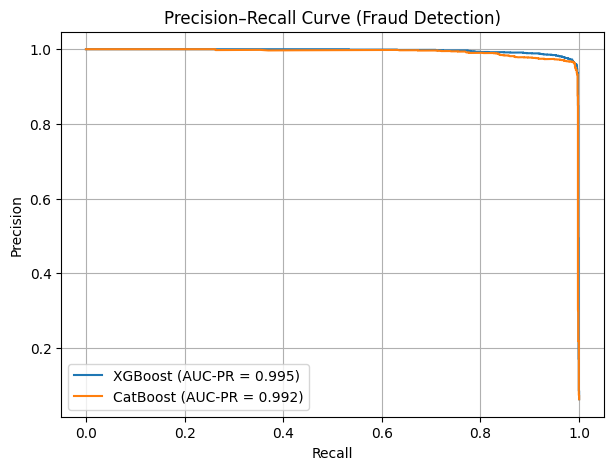

In [135]:
X_test = pd.get_dummies(X_test)

# Align test to train
X_test = X_test.reindex(
    columns=X_train.columns,
    fill_value=0
)

# Get predicted probabilities for the positive class
xgb_probs = xgb_final_model.predict_proba(X_test[selected_topk])[:, 1]
cbc_probs = cbc_final_model.predict_proba(X_test[selected_topk])[:, 1]

# Calculate Precision, Recall values
xgb_precision, xgb_recall, _ = precision_recall_curve(Y_test, xgb_probs)
cbc_precision, cbc_recall, _ = precision_recall_curve(Y_test, cbc_probs)

# Compute AUC (area under the PR curve)
xgb_pr_auc = auc(xgb_recall, xgb_precision)
cbc_pr_auc = auc(cbc_recall, cbc_precision)

# You can also use average_precision_score (same meaning but slightly different calc)
xgb_ap = average_precision_score(Y_test, xgb_probs)
cbc_ap = average_precision_score(Y_test, cbc_probs)

print(f"XGBoost PR-AUC: {xgb_pr_auc:.4f} | Avg Precision: {xgb_ap:.4f}")
print(f"CatBoost PR-AUC: {cbc_pr_auc:.4f} | Avg Precision: {cbc_ap:.4f}")

# --- Plot the PR Curves ---
plt.figure(figsize=(7, 5))
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC-PR = {xgb_pr_auc:.3f})')
plt.plot(cbc_recall, cbc_precision, label=f'CatBoost (AUC-PR = {cbc_pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Fraud Detection)')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
# Select best model between two
if xgb_pr_auc > cbc_pr_auc:
    best_model = xgb_final_model
else:
    best_model = cbc_final_model

# # Merge original dataset with balanced dataset
# df_new = df.merge(balanced_class_df, how='left', indicator=True)

# # Extract unseen (left-only) rows as test data
# test_df = df_new[df_new['_merge'] == 'left_only'].drop(columns=['_merge'])

print(len(X_train), len(X_test), len(Y_train), len(Y_test))
# Generate probability predictions using the trained XGBoost model
y_prob = best_model.predict_proba(X_test[selected_topk])[:, 1]

# Convert probabilities to binary predictions using optimal threshold
y_pred = (y_prob >= xgb_threshold).astype(int)

# Display predictions
y_pred

105126 26282 105126 26282


array([0, 0, 0, ..., 0, 0, 0], shape=(26282,))

In [137]:
# # Add y_pred to test df
print(len(Y_test))
# Y_test["fraud_prediction"] = y_pred

26282


In [138]:
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

Confusion Matrix:
 [[24556    71]
 [    9  1646]]


In [139]:
print("Classification Report:\n", classification_report(Y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24627
           1       0.96      0.99      0.98      1655

    accuracy                           1.00     26282
   macro avg       0.98      1.00      0.99     26282
weighted avg       1.00      1.00      1.00     26282



In [140]:
y_prob = best_model.predict_proba(rem_encoding[selected_topk])[:, 1]

# Convert probabilities to binary predictions using optimal threshold
y_pred = (y_prob >= xgb_threshold).astype(int)

# Display predictions
y_pred

array([0, 0, 0, ..., 1, 0, 0], shape=(6231199,))

In [141]:
print("Confusion Matrix:\n", confusion_matrix(rem_y, y_pred))

Confusion Matrix:
 [[6214454   16745]
 [      0       0]]


In [142]:
print("Classification Report:\n", classification_report(rem_y, y_pred))

c:\Users\manju\DS_&_DA\Fraud_Detection\FD\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manju\DS_&_DA\Fraud_Detection\FD\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   6231199
           1       0.00      0.00      0.00         0

    accuracy                           1.00   6231199
   macro avg       0.50      0.50      0.50   6231199
weighted avg       1.00      1.00      1.00   6231199



c:\Users\manju\DS_&_DA\Fraud_Detection\FD\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
